In [1]:
import os
import json
import pyqg_subgrid_experiments as pse
from pyqg_subgrid_experiments.models import ProbabilisticCNN
import argparse
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_set', type=str, default="/scratch/zanna/data/pyqg/data/train/0.nc")
parser.add_argument('--test_set', type=str, default="/scratch/zanna/data/pyqg/data/test/*.nc")
parser.add_argument('--transfer_set', type=str, default="/scratch/zanna/data/pyqg/data/transfer/*.nc")
parser.add_argument('--save_dir', type=str, default="PCNN")
parser.add_argument('--inputs', type=str, default="u,v,q")
parser.add_argument('--targets', type=str, default="q_forcing_advection")
parser.add_argument('--zero_mean', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--layerwise_inputs', type=int, default=0)
parser.add_argument('--layerwise_targets', type=int, default=0)
args = parser.parse_args("")

In [4]:
train = pse.Dataset(args.train_set)

In [54]:
save_dir = args.save_dir
test_dir = os.path.join(save_dir, "test")
xfer_dir = os.path.join(save_dir, "transfer")
os.system(f"rm -r {save_dir}")
for d in [save_dir, test_dir, xfer_dir]:
    os.system(f"mkdir -p {d}") 

In [55]:
with open(f"{save_dir}/model_config.json", 'w') as f:
    f.write(json.dumps(args.__dict__))

In [56]:
param = pse.CNNParameterization.train_on(train, save_dir,
            inputs=args.inputs.split(","),
            targets=args.targets.split(","),
            layerwise_inputs=True,
            layerwise_targets=True,
            zero_mean=args.zero_mean,
            num_epochs=50,
            model_class=ProbabilisticCNN,
            learning_rate=0.0001)

Gauss Loss after Epoch 1: 3.902721643447876, equiv MSE: 902.7478575404386
Gauss Loss after Epoch 2: 2.206973910331726, equiv MSE: 30.384962173011864
Gauss Loss after Epoch 3: 1.662390947341919, equiv MSE: 10.224449835721138
Gauss Loss after Epoch 4: 1.3209351897239685, equiv MSE: 5.164820658179943
Gauss Loss after Epoch 5: 1.253960371017456, equiv MSE: 4.517328331714475
Gauss Loss after Epoch 6: 0.9193550646305084, equiv MSE: 2.3133810889156736
Gauss Loss after Epoch 7: 0.7763558030128479, equiv MSE: 1.73795929509585
Gauss Loss after Epoch 8: 0.7273851931095123, equiv MSE: 1.5758115134507515
Gauss Loss after Epoch 9: 0.72499880194664, equiv MSE: 1.5683084276513042
Gauss Loss after Epoch 10: 0.5877320766448975, equiv MSE: 1.191799265802626
Gauss Loss after Epoch 11: 0.4639453738927841, equiv MSE: 0.930429238803469
Gauss Loss after Epoch 12: 0.7088121771812439, equiv MSE: 1.5183502056309346
Gauss Loss after Epoch 13: 0.3948017507791519, equiv MSE: 0.8102629142877619
Gauss Loss after Epoc

In [59]:
for i, model in enumerate(param.models):
    print('model number', i)
    model.check_channels()

model number 0
min, max std : 0.09185075759887695 2.821894407272339
min, max mean: -2.3964152336120605 2.9409732818603516
model number 1
min, max std : 0.06960272789001465 2.8678829669952393
min, max mean: -2.1837615966796875 2.207934856414795


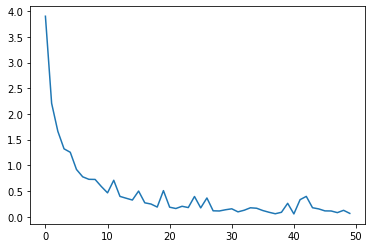

In [60]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(param.models[0].loss_history['gauss'])